In [65]:
# !pip install mne
# !pip install autoreject

In [66]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne

from autoreject import AutoReject

In [67]:

mne.set_log_level('error')

In [68]:
data_dir = "Processed"
p_num = 5

In [69]:
raw = mne.io.read_raw_fif(f"{data_dir}/P{p_num}/P{p_num}-raw.fif", preload=True)
montage = "standard_1020"
raw.set_montage(montage)  

<Raw | P5-raw.fif, 8 x 525842 (2103.4 s), ~32.1 MiB, data loaded>

In [ ]:

ica_low_cut = 1.0 
hi_cut  = 40

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)


# low_cut = 1.0 
# hi_cut  = 40
# raw_ica = raw.copy().notch_filter(60)
# raw_ica.filter(l_freq=low_cut, h_freq=hi_cut)

In [71]:

tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

In [72]:
# This can take a long time to run, don't worry (6.5 mins for me)

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)

reject_log = ar.get_reject_log(epochs_ica)

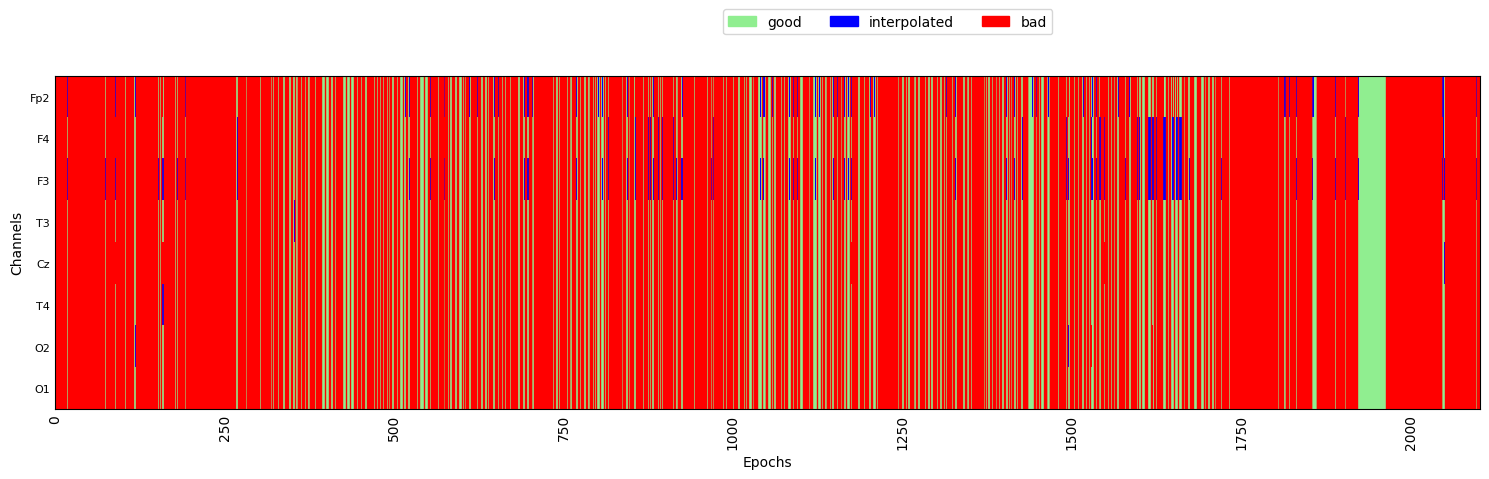

In [73]:

fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()


In [74]:

# ICA parameters
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=42, # seed
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,13 iterations on epochs (102900 samples)
ICA components,7
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


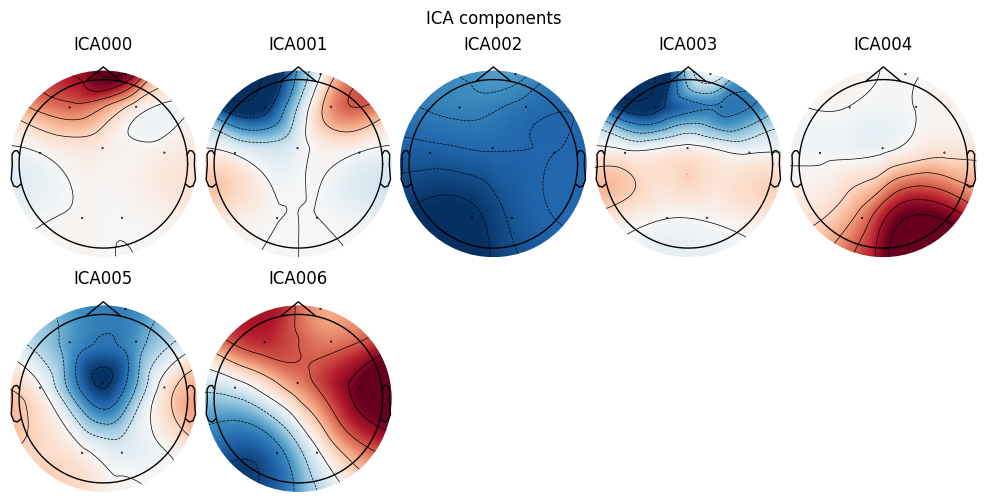

In [75]:
# # ICA Component Plot
ica.plot_components();  # not sure what this semicolon does? it seems to keep it from printing twice though

In [76]:
# # ICA Plot 2
# ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': hi_cut});

In [77]:
ica.exclude = []
num_excl = 0
max_ic = 2
z_thresh = 3.5
z_step = .05

while num_excl < max_ic:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                                ch_name=['Fp2', 'F3', 'F4'], 
                                                threshold=z_thresh
                                                )
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

# assign the bad EOG components to the ICA.exclude attribute so they can be removed later
ica.exclude = eog_indices

print('Final z threshold = ' + str(round(z_thresh, 2)))

Final z threshold = 1.95


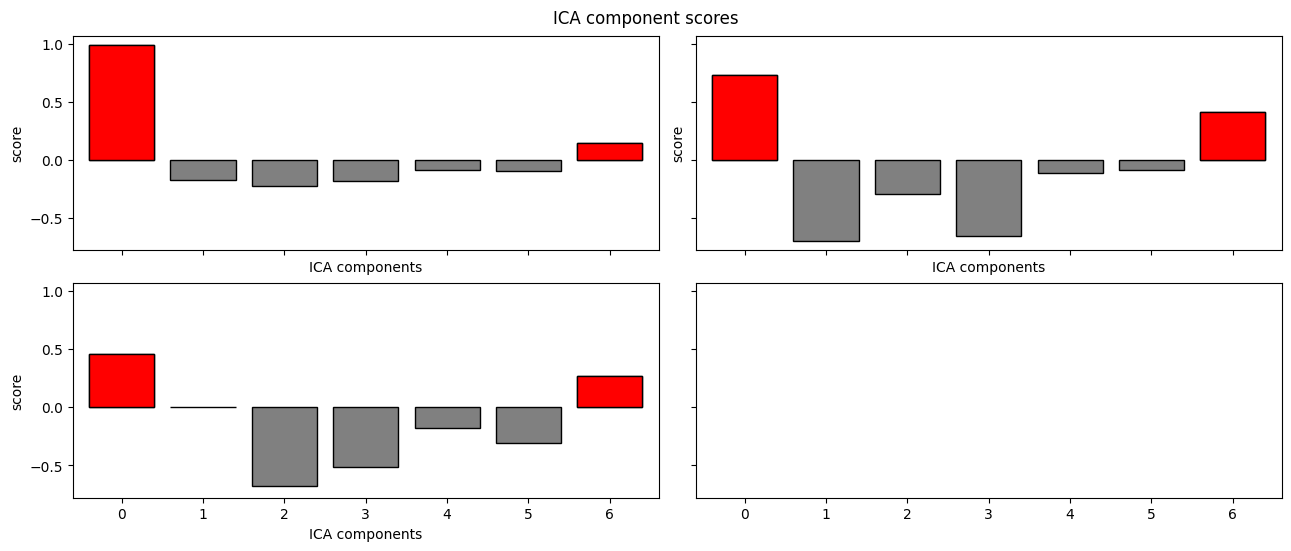

In [78]:
ica.plot_scores(eog_scores);

In [79]:
ica.save(f"{data_dir}/P{p_num}/P{p_num}-ica.fif", overwrite=True)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,13 iterations on epochs (102900 samples)
ICA components,7
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,ICA000ICA006
